#  GP latent function inference

This notebook uses GP to infer a latent function $\lambda(x)$, which parameterises the exponential distribution:
$$(y_1, y_2) \sim SomeCopula(\lambda),$$
where:
$$\lambda = (2 \cdot \Phi(f) - 1) \in (-1,+1)$$
is a GP link function, which transforms the latent gaussian process variable:
$$f \sim GP \in (-\infty,+\infty).$$

In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import numpy as np

from bvcopula import GaussianCopula, GaussianCopula_Likelihood, GaussianCopula_Flow_Likelihood
from bvcopula import FrankCopula, FrankCopula_Likelihood
from bvcopula import ClaytonCopula, ClaytonCopula_Likelihood
from bvcopula import GumbelCopula, GumbelCopula_Likelihood
from bvcopula import StudentTCopula, StudentTCopula_Likelihood
#from bvcopula import MixtureCopula, MixtureCopula_Likelihood
from bvcopula import GPInferenceModel, KISS_GPInferenceModel

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
#here we specify a 'true' latent function lambda
scale = lambda x: 0.7*np.sin(np.pi*3*x)#*np.cos(2*np.pi*3*x+0.3)*5.+6. #np.sin(2*np.pi*3*x+.6)

In [3]:
np.around(0.0543653,2)

0.05

(5000, 2)


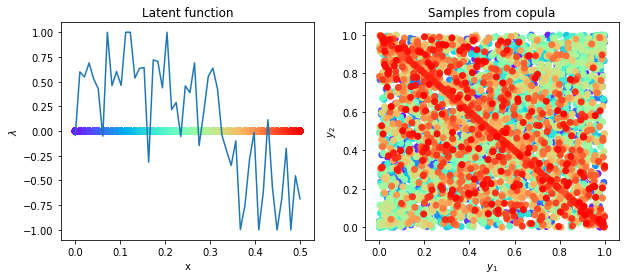

In [4]:
# here we generate some synthetic samples
import matplotlib.cm as cm
from gpytorch.distributions import base_distributions

NSamp = int(50)

X = np.linspace(0.,.5,NSamp)

fig, (lambdaf, samples) = plt.subplots(1,2,figsize=(10,4))

scales = np.clip([scale(x) for x in X]+0.4*base_distributions.Normal(0,1).sample(torch.Size([NSamp])).numpy(),-1,1)
rep = 100
scales = np.repeat(scales,rep,axis=0)
X = np.repeat(X,rep,axis=0)
NSamp = NSamp*rep

lambdaf.plot(X,scales)
lambdaf.set_xlabel('x')
lambdaf.set_ylabel('$\lambda$')
lambdaf.set_title('Latent function')

model = GaussianCopula(torch.tensor(scales).float())
Y = model.sample().numpy().squeeze()
print(Y.shape)
colors = cm.rainbow(np.linspace(0., 1., NSamp))
lambdaf.scatter(X,np.zeros_like(X),color=colors)
samples.scatter(*Y.T, color=colors)
samples.set_xlabel('$y_1$')
samples.set_ylabel('$y_2$')
samples.set_title('Samples from copula')

fig.show()

In [5]:
Y[Y!=Y]

array([], dtype=float32)

In [6]:
Y[Y==1]

array([], dtype=float32)

In [7]:
#convert numpy data to tensors (optionally on GPU)
train_x = torch.tensor(X).float().cuda(device=0)
train_y = torch.tensor(Y).float().cuda(device=0)

In [8]:
from gpytorch.kernels.grid_kernel import GridKernel
from gpytorch.lazy import InterpolatedLazyTensor
from gpytorch.models.exact_prediction_strategies import InterpolatedPredictionStrategy
from gpytorch.utils.interpolation import Interpolation

from gpytorch.mlls import InducingPointKernelAddedLossTerm
from gpytorch.distributions import MultivariateNormal
from gpytorch.lazy import delazify, DiagLazyTensor, MatmulLazyTensor, RootLazyTensor, PsdSumLazyTensor

class myGridInterpolationKernel(GridKernel):

    def __init__(self, base_kernel, grid_size, likelihood, num_dims=None, grid_bounds=None, active_dims=None):
        has_initialized_grid = 0
        grid_is_dynamic = True

        # Make some temporary grid bounds, if none exist
        if grid_bounds is None:
            if num_dims is None:
                raise RuntimeError("num_dims must be supplied if grid_bounds is None")
            else:
                # Create some temporary grid bounds - they'll be changed soon
                grid_bounds = tuple((-1.0, 1.0) for _ in range(num_dims))
        else:
            has_initialized_grid = 1
            grid_is_dynamic = False
            if num_dims is None:
                num_dims = len(grid_bounds)
            elif num_dims != len(grid_bounds):
                raise RuntimeError(
                    "num_dims ({}) disagrees with the number of supplied "
                    "grid_bounds ({})".format(num_dims, len(grid_bounds))
                )

        # Initialize values and the grid
        self.grid_is_dynamic = grid_is_dynamic
        self.num_dims = num_dims
        self.grid_size = grid_size
        self.grid_bounds = grid_bounds
        grid = self._create_grid()

        super(myGridInterpolationKernel, self).__init__(
            base_kernel=base_kernel, grid=grid, interpolation_mode=True, active_dims=active_dims
        )
        self.likelihood = likelihood
        self.register_buffer("has_initialized_grid", torch.tensor(has_initialized_grid, dtype=torch.bool))
        self.register_added_loss_term("grid_interpolation_loss_term")


    def _create_grid(self):
        grid = torch.zeros(self.grid_size, len(self.grid_bounds))
        for i in range(len(self.grid_bounds)):
            grid_diff = float(self.grid_bounds[i][1] - self.grid_bounds[i][0]) / (self.grid_size - 2)
            grid[:, i] = torch.linspace(
                self.grid_bounds[i][0] - grid_diff, self.grid_bounds[i][1] + grid_diff, self.grid_size
            )

        return grid

    @property
    def _tight_grid_bounds(self):
        grid_spacings = tuple((bound[1] - bound[0]) / self.grid_size for bound in self.grid_bounds)
        return tuple(
            (bound[0] + 2.01 * spacing, bound[1] - 2.01 * spacing)
            for bound, spacing in zip(self.grid_bounds, grid_spacings)
        )

    def _compute_grid(self, inputs, last_dim_is_batch=False):
        n_data, n_dimensions = inputs.size(-2), inputs.size(-1)
        if last_dim_is_batch:
            inputs = inputs.transpose(-1, -2).unsqueeze(-1)
            n_dimensions = 1
        batch_shape = inputs.shape[:-2]

        inputs = inputs.reshape(-1, n_dimensions)
        interp_indices, interp_values = Interpolation().interpolate(self.grid, inputs)
        interp_indices = interp_indices.view(*batch_shape, n_data, -1)
        interp_values = interp_values.view(*batch_shape, n_data, -1)
        return interp_indices, interp_values

    def _covar_diag(self, inputs):
        if inputs.ndimension() == 1:
            inputs = inputs.unsqueeze(1)

        # Get diagonal of covar
        covar_diag = delazify(self.base_kernel(inputs, diag=True))
        return DiagLazyTensor(covar_diag)

    def _inducing_forward(self, last_dim_is_batch, **params):
        return super().forward(self.grid, self.grid, last_dim_is_batch=last_dim_is_batch, **params)

    def forward(self, x1, x2, diag=False, last_dim_is_batch=False, **params):
        # See if we need to update the grid or not
        if self.grid_is_dynamic:  # This is true if a grid_bounds wasn't passed in
            if torch.equal(x1, x2):
                x = x1.reshape(-1, self.num_dims)
            else:
                x = torch.cat([x1.reshape(-1, self.num_dims), x2.reshape(-1, self.num_dims)])
            x_maxs = x.max(0)[0].tolist()
            x_mins = x.min(0)[0].tolist()

            # We need to update the grid if
            # 1) it hasn't ever been initialized, or
            # 2) if any of the grid points are "out of bounds"
            update_grid = (not self.has_initialized_grid.item()) or any(
                x_min < bound[0] or x_max > bound[1]
                for x_min, x_max, bound in zip(x_mins, x_maxs, self._tight_grid_bounds)
            )

            # Update the grid if needed
            if update_grid:
                grid_spacings = tuple((x_max - x_min) / (self.grid_size - 4.02) for x_min, x_max in zip(x_mins, x_maxs))
                self.grid_bounds = tuple(
                    (x_min - 2.01 * spacing, x_max + 2.01 * spacing)
                    for x_min, x_max, spacing in zip(x_mins, x_maxs, grid_spacings)
                )
                grid = self._create_grid()
                self.update_grid(grid)

        base_lazy_tsr = self._inducing_forward(last_dim_is_batch=last_dim_is_batch, **params)
        if last_dim_is_batch:
            base_lazy_tsr = base_lazy_tsr.repeat(*x1.shape[:-2], x1.size(-1), 1, 1)
        if x1.dim() > 2:
            base_lazy_tsr = base_lazy_tsr.repeat(*x1.shape[:-2], 1, 1)

        left_interp_indices, left_interp_values = self._compute_grid(x1, last_dim_is_batch)
        if torch.equal(x1, x2):
            right_interp_indices = left_interp_indices
            right_interp_values = left_interp_values
        else:
            right_interp_indices, right_interp_values = self._compute_grid(x2, last_dim_is_batch)

        covar = InterpolatedLazyTensor(
            base_lazy_tsr,
            left_interp_indices.detach(),
            left_interp_values,
            right_interp_indices.detach(),
            right_interp_values,
        )
        
        zero_mean = torch.zeros_like(x1.select(-1, 0))
        new_added_loss_term = InducingPointKernelAddedLossTerm(
            MultivariateNormal(zero_mean, self._covar_diag(x1)),
            MultivariateNormal(zero_mean, covar),
            self.likelihood,
        )
       
        self.update_added_loss_term("grid_interpolation_loss_term", new_added_loss_term)

        if diag:
            return covar.diag()
        else:
            return covar

    def prediction_strategy(self, train_inputs, train_prior_dist, train_labels, likelihood):
        return InterpolatedPredictionStrategy(train_inputs, train_prior_dist, train_labels, likelihood)

    def num_outputs_per_input(self, x1, x2):
        return self.base_kernel.num_outputs_per_input(x1, x2)

In [9]:
class myKISS_GPInferenceModel(gpytorch.models.AbstractVariationalGP):
    def __init__(self, likelihood, prior_rbf_length=0.1, grid_size=128, grid_bounds=[(0, 1)]):
        # Define all the variational stuff
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(grid_size)
        variational_strategy = gpytorch.variational.GridInterpolationVariationalStrategy(
            self, grid_size, grid_bounds, variational_distribution
        )
        
        # Standard initializtation
        super(myKISS_GPInferenceModel, self).__init__(variational_strategy)
        self.likelihood = likelihood
        
        # Mean, covar
        self.mean_module = gpytorch.means.ConstantMean()
        
        #we specify prior here
        lengthscale_prior = gpytorch.priors.NormalPrior(prior_rbf_length, 1.0) #variance does not matter much
        
        self.covar_module = myGridInterpolationKernel(
            gpytorch.kernels.ScaleKernel(
                gpytorch.kernels.RBFKernel(lengthscale_prior=lengthscale_prior),
            ), grid_size=grid_size, likelihood=likelihood, num_dims=1
        )
        
        # Initialize lengthscale and outputscale to mean of priors
        self.covar_module.base_kernel.base_kernel.lengthscale = lengthscale_prior.mean
        #self.covar_module.outputscale = outputscale_prior.mean

    def forward(self, x):
        mean = self.mean_module(x)  # Returns an n_data vec
        covar = self.covar_module(x)
        assert all(mean==mean)
        return gpytorch.distributions.MultivariateNormal(mean, covar)

In [11]:
from gpytorch.mlls.marginal_log_likelihood import MarginalLogLikelihood
from gpytorch import settings

class myVariationalELBO(MarginalLogLikelihood):
    def __init__(self, likelihood, model, num_data, combine_terms=True):
        """
        A special MLL designed for variational inference
        Args:
        - likelihood: (Likelihood) - the likelihood for the model
        - model: (Module) - the variational GP model
        - num_data: (int) - the total number of training data points (necessary for SGD)
        - combine_terms: (bool) - whether or not to sum the expected NLL with the KL terms (default True)
        """
        super(myVariationalELBO, self).__init__(likelihood, model)
        self.combine_terms = combine_terms
        self.num_data = num_data

    def forward(self, variational_dist_f, target, **kwargs):
        num_batch = variational_dist_f.event_shape.numel()

        log_likelihood = self.likelihood.expected_log_prob(target, variational_dist_f, **kwargs).div(
            num_batch
        )
        kl_divergence = self.model.variational_strategy.kl_divergence()

        if kl_divergence.dim() > log_likelihood.dim():
            kl_divergence = kl_divergence.sum(-1)

        if log_likelihood.numel() == 1:
            kl_divergence = kl_divergence.sum()

        kl_divergence = kl_divergence.div(self.num_data)

        # Add any additional registered loss terms
        added_loss = torch.zeros_like(kl_divergence)
        had_added_losses = False
        for added_loss_term in self.model.added_loss_terms():
            added_loss.add_(added_loss_term.loss().squeeze())
            had_added_losses = True

        if self.combine_terms:
            res = log_likelihood - kl_divergence
            for _, prior, closure, _ in self.named_priors():
                res.add_(prior.log_prob(closure()).sum().div(self.num_data))
            return res + added_loss
        else:
            log_prior = torch.zeros_like(log_likelihood)
            for _, prior, closure, _ in self.named_priors():
                log_prior.add_(prior.log_prob(closure()).sum())
            if had_added_losses:
                return log_likelihood, kl_divergence, log_prior.div(self.num_data), added_loss
            else:
                return log_likelihood, kl_divergence, log_prior.div(self.num_data)

In [12]:
# define the model (optionally on GPU)
grid_size = 128

#model = GPInferenceModel(train_x, GaussianCopula_Likelihood()).cuda(device=0)
#likelihood = GaussianCopula_Likelihood().cuda(device=0)
model = myKISS_GPInferenceModel(GaussianCopula_Likelihood(), prior_rbf_length=0.3, grid_size=grid_size).cuda(device=0)

In [13]:
#model.likelihood.noise = 1e-4

In [14]:
# train the model

base_lr = 0.01
iter_print = 100

print('Basic lr for most of parameters: {}'.format(base_lr))

# We use SGD here, rather than Adam. Emperically, we find that SGD is better for variational regression
optimizer = torch.optim.Adam([
    {'params': model.mean_module.parameters()},
    {'params': model.variational_strategy.variational_distribution.chol_variational_covar},
    {'params': model.variational_strategy.variational_distribution.variational_mean},
    #hyperparameters
    {'params': model.covar_module.base_kernel.base_kernel.raw_lengthscale, 'lr': .001}, #, 'lr': 0.001
    {'params': model.covar_module.base_kernel.raw_outputscale, 'lr': .001},
    {'params': model.likelihood.noise_covar.raw_noise, 'lr': .001} #should change slower than variance
], lr=base_lr)

# Our loss object. We're using the VariationalELBO, which essentially just computes the ELBO
#mll  = gpytorch.mlls.VariationalELBO(model.likelihood, model, num_data=train_y.size(0), combine_terms=True)
mllv = myVariationalELBO(model.likelihood, model, num_data=train_y.size(0), combine_terms=False)

losses, rbf, means, noises = [], [], [], []

def train(train_x, train_y, num_iter=2000):
    model.train()

    p = 0.
    nans=0
    for i in range(num_iter):
        optimizer.zero_grad()
        output = model(train_x)
        assert torch.all(output.mean==output.mean)
        #loss = -mll(output, train_y)# - 0.01*(model.covar_module.base_kernel.lengthscale*grid_size).log().sum()
        #print(loss)
        log_lik, kl_div, log_prior, added_loss = mllv(output, train_y)
        loss = -(log_lik-kl_div+log_prior+added_loss)
#         if i==1900:
#             log_lik, kl_div, log_prior, added = mllv(output, train_y)
#             print(log_lik, kl_div, log_prior, added)
#             model.likelihood.noise = 1e-4
#             log_lik, kl_div, log_prior, added = mllv(output, train_y)
#             print(log_lik, kl_div, log_prior, added)
#             break
        if len(losses)>100: 
            p += np.abs(np.mean(losses[-50:]) - np.mean(losses[-100:-50]))
        losses.append(loss.detach().cpu().numpy())
        rbf.append(model.covar_module.base_kernel.base_kernel.lengthscale.item())
        means.append(model.variational_strategy.variational_distribution.variational_mean.detach().cpu().numpy())
        noises.append(model.likelihood.noise_covar.raw_noise_constraint.transform(model.likelihood.noise_covar.raw_noise).item())
        if not (i + 1) % iter_print:
            
            mean_p = p/100
            print('Iter {}/{} - Loss: {:.3}, len: {:.3}, outscale: {:.3} noise: {:.3}, dLoss: {:.3}, \
            mean f: {:.3}, dmean: {:.3}, NaNs fixed: {}'.format(
                i + 1, num_iter, loss,
                model.covar_module.base_kernel.base_kernel.lengthscale.item(), 
                model.covar_module.base_kernel.raw_outputscale.item(),
                model.likelihood.noise_covar.raw_noise_constraint.transform(model.likelihood.noise_covar.raw_noise).item(),
                mean_p, np.mean(means[-1]), 
                np.mean(np.abs(means[-100]-means[-1])),
                nans
            ))
            nans=0

            if (0 < mean_p < 0.0001):# & (np.mean(np.abs(1-means[-100]/means[-1])) < 0.05): 
                print("Converged!")
                break
            p = 0.

        # The actual optimization step
        loss.backward()
        for par in model.parameters():
            grad = par.grad.data
            nans+=torch.nonzero(grad!=grad).shape[0]
            if torch.any(grad.abs()==float('inf')):
                print("Grad inf... fixing...")
                grad = torch.clamp(grad,-1.,1.)
            grad[grad!=grad] = 0.0
            par.grad.data = grad
        covar_grad = model.variational_strategy.variational_distribution.chol_variational_covar.grad
        assert torch.all(covar_grad==covar_grad)
        
        optimizer.step()
        
%time train(train_x,train_y)

Basic lr for most of parameters: 0.01
Iter 100/2000 - Loss: 0.0541, len: 0.278, outscale: 0.0952 noise: 0.648, dLoss: 0.0,             mean f: 0.0422, dmean: 0.353, NaNs fixed: 0
Iter 200/2000 - Loss: -0.0244, len: 0.268, outscale: 0.151 noise: 0.607, dLoss: 0.122,             mean f: -0.00357, dmean: 0.0984, NaNs fixed: 0
Iter 300/2000 - Loss: -0.0411, len: 0.26, outscale: 0.204 noise: 0.568, dLoss: 0.0291,             mean f: -0.0503, dmean: 0.0614, NaNs fixed: 0
Iter 400/2000 - Loss: -0.0518, len: 0.254, outscale: 0.239 noise: 0.533, dLoss: 0.00858,             mean f: -0.0694, dmean: 0.02, NaNs fixed: 0
Iter 500/2000 - Loss: -0.0615, len: 0.249, outscale: 0.264 noise: 0.499, dLoss: 0.00923,             mean f: -0.068, dmean: 0.011, NaNs fixed: 0
Iter 600/2000 - Loss: -0.0891, len: 0.243, outscale: 0.285 noise: 0.469, dLoss: 0.00693,             mean f: -0.0553, dmean: 0.0212, NaNs fixed: 0
Iter 700/2000 - Loss: -0.105, len: 0.237, outscale: 0.305 noise: 0.44, dLoss: 0.00638,       

KeyboardInterrupt: 

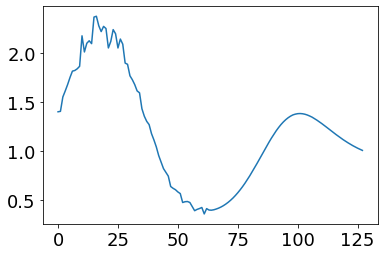

In [22]:
plt.plot(np.exp(means[-1]))
losses[losses!=losses] = 0

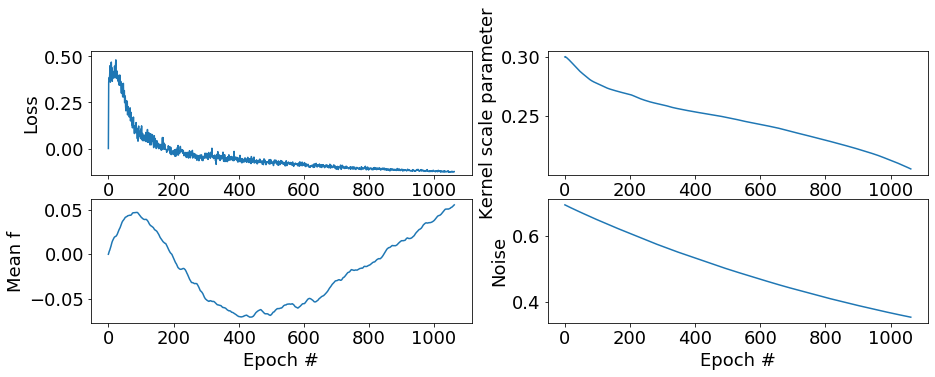

In [23]:
# prot loss function and kernel length
fig, ((lossp, kern), (mean, noise)) = plt.subplots(2,2,figsize=(15,5))
lossp.plot(losses)
lossp.set_xlabel("Epoch #")
lossp.set_ylabel("Loss")
lossp.set_ylim(np.min(losses)*1.1,np.max(losses)*1.1)
kern.plot(rbf)
kern.set_xlabel("Epoch #")
kern.set_ylabel("Kernel scale parameter")
mean.plot([np.mean(x) for x in means])
mean.set_xlabel("Epoch #")
mean.set_ylabel("Mean f")
noise.plot(noises)
noise.set_xlabel("Epoch #")
noise.set_ylabel("Noise")
fig.show()

In [24]:
# define test set (optionally on GPU)
denser = 1 # make test set 2 times denser then the training set
testX = np.linspace(0,1,denser*NSamp)
test_x = torch.tensor(testX).float().cuda(device=0)

marginal
marginal


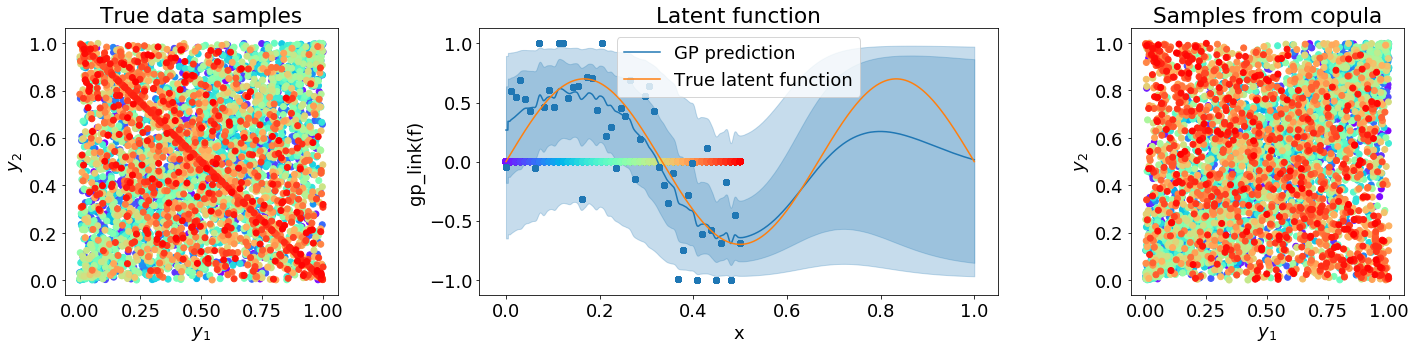

In [25]:
# visualize the result
fig, (true, nul0, nul, sim) = plt.subplots(1,4,figsize=(24, 4.9))

nul0.set_axis_off()
nul.set_axis_off()

plt.rcParams.update({'font.size': 18})

func = fig.add_axes([.365,0.125,.3,.755])

model.eval()
with torch.no_grad():
    #output = model(test_x)
    output = model.likelihood(model(test_x))
    
gplink = model.likelihood.gplink_function
 
#samples = output.rsample(torch.Size([int(1e5)]))
#F_mean = gplink(samples).mean(0).detach().cpu().numpy()
F_mean = gplink(output.mean).detach().cpu().numpy()
line, = func.plot(testX, F_mean, label = 'GP prediction')
lower, upper = output.confidence_region()
noise = model.likelihood.noise_covar.raw_noise_constraint.transform(model.likelihood.noise_covar.raw_noise).item()
func.fill_between(testX, gplink(lower+2*noise).detach().cpu().numpy(),
                gplink(upper-2*noise).detach().cpu().numpy(), color=line.get_color(), alpha=0.25)
func.fill_between(testX, gplink(lower).detach().cpu().numpy(),
                gplink(upper).detach().cpu().numpy(), color=line.get_color(), alpha=0.25)

func.plot(testX,scale(testX), label = 'True latent function')
func.scatter(X,np.zeros_like(X),color=colors)
func.scatter(X,scales)
func.set_xlabel('x')
func.set_ylabel('gp_link(f)')
func.set_title('Latent function')
func.legend()

# sample from p(y|D,x) = \int p(y|f) p(f|D,x) (doubly stochastic)
with gpytorch.settings.num_likelihood_samples(1):
    Y_sim = model.likelihood.forward(model.likelihood(model(train_x)).sample()).rsample().cpu().detach().numpy()
#model() -- returns GP (Multivariate normal) without noise
#model.likelihood(model) -- calls likelihood.marginal and adds noise (returns Multivariate normal)
#model.likelihood.forward(samples) -- returns copula samples
skip = 1
true.scatter(*Y[::skip].T, label = 'True train data', color=colors[::skip])
sim.scatter(*Y_sim[::skip].T, label = 'Sample from the model', color=colors[::skip])
for ax in [sim,true]:
    ax.set_xlabel('$y_1$')
    ax.set_ylabel('$y_2$')
sim.set_title('Samples from copula')
true.set_title('True data samples')
# samp.legend()

plt.subplots_adjust(wspace=0.3)

plt.savefig('poster_img/gp.svg')

In [36]:
noise = model.likelihood.noise
log_lik, kl_div, log_prior, added_loss = mllv(output, train_y)
print(log_lik, added_loss, log_lik + added_loss)
model.likelihood.noise = 1e-4
log_lik, kl_div, log_prior, added_loss = mllv(output, train_y)
print(log_lik, added_loss, log_lik + added_loss)
model.likelihood.noise = noise

tensor(-0.2901, device='cuda:0', grad_fn=<DivBackward0>) tensor(-3.7081e-05, device='cuda:0', grad_fn=<AddBackward0>) tensor(-0.2901, device='cuda:0', grad_fn=<AddBackward0>)
setter_all
tensor(-0.2513, device='cuda:0', grad_fn=<DivBackward0>) tensor(-0.1311, device='cuda:0', grad_fn=<AddBackward0>) tensor(-0.3824, device='cuda:0', grad_fn=<AddBackward0>)
setter_all


In [20]:
cov = model(test_x).covariance_matrix
diag1=[cov[i,i].item() for i in range(len(X))]
cov = model.likelihood(model(test_x)).covariance_matrix
diag2=[cov[i,i].item() for i in range(len(X))]

marginal


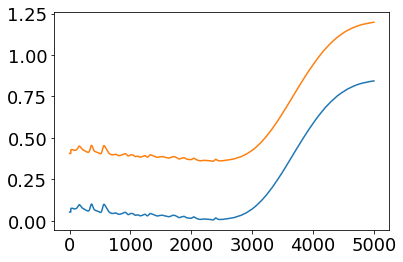

In [21]:
plt.plot(diag1)
plt.plot(diag2)